# Fairness Checking: Demographic Parity Constraint Experiment
This notebook uses PuLP to solve the linear program outlined in the "Fairness Checking" document. Here, **we experiment with varying the upper bound constraint on w and see its effects on the objective value.**

In [1]:
!pip install pulp

     |████████████████████████████████| 40.6 MB 37.9 MB/s eta 0:00:01     |██████████████████████▏         | 28.2 MB 37.9 MB/s eta 0:00:01


In [2]:
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt
import collections

In [3]:
# Run this cell to mount your Google Drive.
# from google.colab import drive
# drive.mount('/content/drive')

## Import Predicted Data
We take A (the protected attribute) to be the 'race' variable, and a = 0 while a' = 1. The last column, 'prediction,' is our f(X) variable, which can either be 0 or 1.

In [4]:
algorithm_used = 'preprocessing' # preprocessing, inprocessing, postprocessing
pred_df = pd.read_csv('./../../predicted_data/{}/{}_logreg_compas_dp.csv'.format(algorithm_used, algorithm_used))

In [5]:
pred_df.head(5)

,Unnamed: 0,sex,race,age_cat=25 to 45,age_cat=Greater than 45,age_cat=Less than 25,priors_count=0,priors_count=1 to 3,priors_count=More than 3,c_charge_degree=F,c_charge_degree=M,two_year_recid,predictions
0,5578,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
1,2113,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
2,5189,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,10239,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3391,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0


In [6]:
# Our protected variable A is race, and a = 0 or a = 1. 
a = pred_df['race']
np.asarray(a)
a_0_indices = []
a_1_indices = []

for i in range(len(a)):
    if a[i] == 0:
        a_0_indices.append(i)
    elif a[i] == 1:
        a_1_indices.append(i)

In [7]:
# Our pi variables are simply the proportions of a_0 or a_1 
pi_0 = float(len(a_0_indices))/(len(a_0_indices) + len(a_1_indices))
pi_1 = float(len(a_1_indices))/(len(a_0_indices) + len(a_1_indices))

In [8]:
print(pi_0)
print(pi_1)

0.6136363636363636
0.38636363636363635


In [9]:
f_X = pred_df['predictions']
np.asarray(f_X)
pred_df.head(1)

,Unnamed: 0,sex,race,age_cat=25 to 45,age_cat=Greater than 45,age_cat=Less than 25,priors_count=0,priors_count=1 to 3,priors_count=More than 3,c_charge_degree=F,c_charge_degree=M,two_year_recid,predictions
0,5578,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0


In [10]:
# Check if the dimensions match
print(len(f_X))
print(len(a_0_indices) + (len(a_1_indices)))

528
528


## Create Linear Program
We use the PuLP package to create our linear program.

Here, we allow another input for the upper bound on all w's. This must be a number between 0 and 1.

In [11]:
# Input: function f(X), constraint
# Output: (solved) model, weights
def SP_linear_prog(f_X, lower_bound, upper_bound):
  # Check if constraint is between 0 and 1
  assert(0 < lower_bound < 1)
  assert(0 < upper_bound < 1)

  # Define the linear program as a maximization problem
  model = pulp.LpProblem("Statistical Parity Fairness Checking", pulp.LpMaximize)
  
  # Our w variable in the objective
  # Lower bound constraint set here with lowBound=0 option
  w = pulp.LpVariable.dicts("w", (i for i in range(len(f_X))),lowBound=0, cat='Continuous')
  
  # Objective Function
  model += pulp.lpSum(
      [(1./pi_0) * w[index] * f_X[index] for index in a_0_indices] +
      [- (1./pi_1) * w[index] * f_X[index] for index in a_1_indices])
  
  # Constraint that the \sum(w_i * 1{a = 0}) = pi_0
  model += pulp.lpSum([w[index] for index in a_0_indices]) == pi_0
  
  # Constraint that the \sum(w_i * 1{a = 1}) = pi_1
  model += pulp.lpSum([w[index] for index in a_1_indices]) == pi_1
  
  # Constraint that the w's all sum to 1
  model += pulp.lpSum([w[i] for i in range(len(f_X))]) == 1

  # IMPORTANT: Constraint for the w's (experiment with this)
  for weight in w:
    model += w[weight] <= upper_bound
    model += w[weight] >= lower_bound

  # Solve the linear program
  model.solve()
  pulp.LpStatus[model.status]
  
  # Returns the model and the weights
  return model, w

# Get the results
def weights_dictionary(w):
  results_dict = dict()
  for i in range(len(f_X)):
    results_dict[i] = w[i].varValue
  return results_dict

## Experiment with Constraints
Experiment with setting the constraints as: $$w_i \leq \frac{(1 + \gamma)}{n}$$ and $$\frac{(1 - \gamma)}{n} \leq w_i$$ where n is the number of samples in the data.

In [12]:
epsilon_granule = 0.01

lower_bounds = []
upper_bounds = []
objective_values = []
dist_weights = []
epsilons = []

# Iterate over constraints
for i in range(0, 100):
  epsilon = epsilon_granule * i
  lower_bound = (1 - epsilon)/(len(f_X))
  upper_bound = (1 + epsilon)/(len(f_X))
  model, weights = SP_linear_prog(f_X, lower_bound, upper_bound)
  objective_values.append(pulp.value(model.objective))
  epsilons.append(epsilon)
  lower_bounds.append(lower_bound)
  upper_bounds.append(upper_bound)
  dist_weights.append(weights)

/Users/sam/anaconda3/envs/fairness_checking/lib/python3.7/site-packages/pulp/pulp.py:1114: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Text(0.5, 1.0, 'Constraint on w vs. SP LP Objective Value')

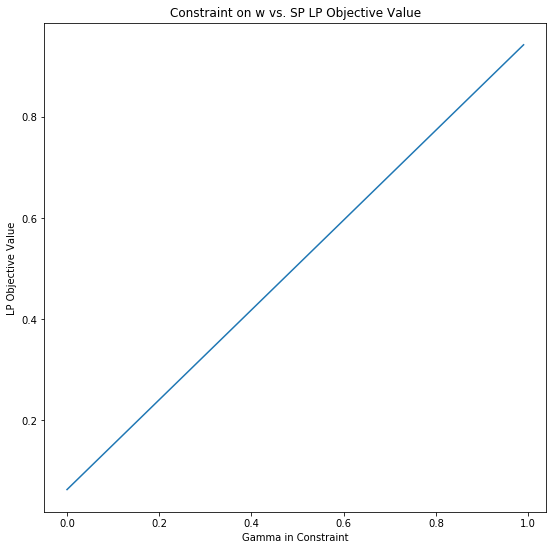

In [13]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(epsilons, objective_values)
plt.xlabel('Gamma in Constraint')
plt.ylabel('LP Objective Value')
plt.title('Constraint on w vs. SP LP Objective Value')

In [14]:
print(len(dist_weights))
print(len(epsilons))

epsilon_to_weights = dict()
for i in range(len(epsilons)):
    epsilon_to_weights[epsilons[i]] = weights_dictionary(dist_weights[i])

100
100


In [15]:
print(len(pred_df))
print(len(epsilon_to_weights[0.01]))

528
528


## Marginal Distributions

In [16]:
# Create a dictionary for our table at the end
table_results = {}

In [17]:
# Find the accuracy of our classifier
tp = len(pred_df[(pred_df['predictions'] == 0) & (pred_df['two_year_recid'] == 0)])
tn = len(pred_df[(pred_df['predictions'] == 1) & (pred_df['two_year_recid'] == 1)])
acc = float(tp + tn)/len(pred_df)

In [18]:
# Find the lowest epsilon value that has a greater than 10% violation
for i in range(len(epsilons)):
    if(objective_values[i] > 0.2):
        lowest_i = i
        break

print(objective_values[lowest_i])
print(epsilons[lowest_i])
table_results['epsilon'] = epsilons[lowest_i]
table_results['initial_unfairness'] = objective_values[0]
table_results['acc'] = acc

0.2054756705342022
0.16


In [19]:
pred_df['weights'] = epsilon_to_weights[epsilons[lowest_i]].values() # For example, when epsilon = 0.2
pred_df.head(5)

,Unnamed: 0,sex,race,age_cat=25 to 45,age_cat=Greater than 45,age_cat=Less than 25,priors_count=0,priors_count=1 to 3,priors_count=More than 3,c_charge_degree=F,c_charge_degree=M,two_year_recid,predictions,weights
0,5578,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.002197
1,2113,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.002197
2,5189,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.002197
3,10239,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.001591
4,3391,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.002197


In [20]:
# Marginal Distribution Function
def marginalize(data, X_attr, weights):
    X_values = data[X_attr]
    key_list = np.unique(X_values)
    X_marginal = {k: 0 for k in key_list}
    for i in range(0, len(X_values)):
        X_marginal[X_values[i]] = X_marginal[X_values[i]] + weights[i]
    return X_marginal

def freq_dict(data, X_attr):
    X_values = data[X_attr].value_counts()
    X_freqs = dict()
    for value in X_values.keys():
        X_freqs[value] = float(X_values[value])/float(len(data))
    return X_freqs

# Returns a tuple of two lists of the items in each dictionary sorted by order of their keys
def graph_tuple(dict1, dict2):
    tuple1 = []
    tuple2 = []
    for key in sorted(dict1.keys()):
        tuple1.append(dict1[key])
        tuple2.append(dict2[key])
    
    return (tuple1, tuple2)

In [21]:
def l1_dist(dict1, dict2):
    l1_total = 0
    for key in sorted(dict1.keys()):
        diff = abs(dict1[key] - dict2[key])
        l1_total = l1_total + diff
        
    return l1_total

{0.0: 0.8184090935000058, 1.0: 0.18159090970000005}


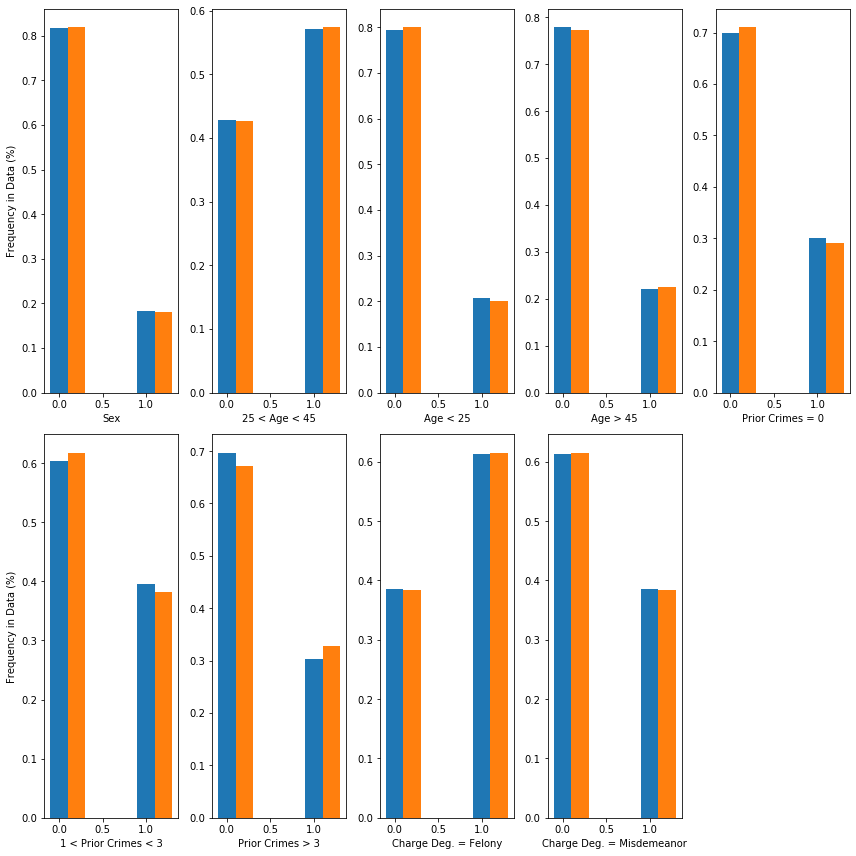

In [28]:
# Get the unweighted and weighted distributions on the data
unweighted_marginal = {}
reweighted_marginal = {}

X_sex_freq = freq_dict(pred_df, 'sex')
X_sex_marginal = marginalize(pred_df, 'sex', pred_df['weights'])
X_sex_tuple = graph_tuple(X_sex_freq, X_sex_marginal)

table_results['sex'] = l1_dist(X_sex_freq, X_sex_marginal)

print(X_sex_marginal)
unweighted_marginal['Sex = M'] = X_sex_freq[0]
reweighted_marginal['Sex = M'] = X_sex_marginal[0]

# Marginal Distribution on Sex 
X = np.arange(len(X_sex_freq))
plt.figure(figsize=(12,12))
plt.subplot(2,5,1)
plt.bar(X, X_sex_tuple[0], width=0.2, align='center')
plt.bar(X+0.2, X_sex_tuple[1], width=0.2, align='center')
plt.xlabel('Sex')
plt.ylabel('Frequency in Data (%)')

X_age_25_45_freq = freq_dict(pred_df, 'age_cat=25 to 45')
X_age_25_45_marginal = marginalize(pred_df, 'age_cat=25 to 45', pred_df['weights'])
X_age_25_45_tuple = graph_tuple(X_age_25_45_freq, X_age_25_45_marginal)

table_results['age_25_45'] = l1_dist(X_age_25_45_freq, X_age_25_45_marginal)

unweighted_marginal['25 <= Age <= 45'] = X_age_25_45_freq[1]
reweighted_marginal['25 <= Age <= 45'] = X_age_25_45_marginal[1]

# Marginal Distribution on Age 
X = np.asarray(list(X_age_25_45_marginal.keys()))
plt.subplot(2,5,2)
plt.bar(X, X_age_25_45_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_25_45_tuple[1], width = 0.2, align='center')
plt.xlabel('25 < Age < 45')

X_age_25_freq = freq_dict(pred_df, 'age_cat=Less than 25')
X_age_25_marginal = marginalize(pred_df, 'age_cat=Less than 25', pred_df['weights'])
X_age_25_tuple = graph_tuple(X_age_25_freq, X_age_25_marginal)

table_results['age_25'] = l1_dist(X_age_25_freq, X_age_25_marginal)

unweighted_marginal['Age < 25'] = X_age_25_freq[1]
reweighted_marginal['Age < 25'] = X_age_25_marginal[1]

# Marginal Distribution on Age 
X = np.asarray(list(X_age_25_marginal.keys()))
plt.subplot(2,5,3)
# plt.title("COMPAS DP Reweighted Marginal Distributions")
plt.bar(X, X_age_25_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_25_tuple[1], width = 0.2, align='center')
plt.xlabel('Age < 25')

X_age_45_freq = freq_dict(pred_df, 'age_cat=Greater than 45')
X_age_45_marginal = marginalize(pred_df, 'age_cat=Greater than 45', pred_df['weights'])
X_age_45_tuple = graph_tuple(X_age_45_freq, X_age_45_marginal)

table_results['age_45'] = l1_dist(X_age_45_freq, X_age_45_marginal)

unweighted_marginal['Age > 45'] = X_age_45_freq[1]
reweighted_marginal['Age > 45'] = X_age_45_marginal[1]

# Marginal Distribution on Age 
X = np.asarray(list(X_age_45_marginal.keys()))
plt.subplot(2,5,4)
plt.bar(X, X_age_45_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_45_tuple[1], width = 0.2, align='center')
plt.xlabel('Age > 45')

X_priors_freq = freq_dict(pred_df, 'priors_count=0')
X_priors_marginal = marginalize(pred_df, 'priors_count=0', pred_df['weights'])
X_priors_tuple = graph_tuple(X_priors_freq, X_priors_marginal)

table_results['priors_0'] = l1_dist(X_priors_freq, X_priors_marginal)

unweighted_marginal['Prior Crimes = 0'] = X_priors_freq[1]
reweighted_marginal['Prior Crimes = 0'] = X_priors_marginal[1]

# Marginal Distribution on Priors 
X = np.asarray(list(X_priors_marginal.keys()))
plt.subplot(2,5,5)
plt.bar(X, X_priors_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_priors_tuple[1], width = 0.2, align='center')
plt.xlabel('Prior Crimes = 0')

X_priors_freq = freq_dict(pred_df, 'priors_count=1 to 3')
X_priors_marginal = marginalize(pred_df, 'priors_count=1 to 3', pred_df['weights'])
X_priors_tuple = graph_tuple(X_priors_freq, X_priors_marginal)

table_results['priors_1_3'] = l1_dist(X_priors_freq, X_priors_marginal)

unweighted_marginal['1 < Prior Crimes < 3'] = X_priors_freq[1]
reweighted_marginal['1 < Prior Crimes < 3'] = X_priors_marginal[1]

# Marginal Distribution on Priors 
X = np.asarray(list(X_priors_marginal.keys()))
plt.subplot(2,5,6)
plt.bar(X, X_priors_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_priors_tuple[1], width = 0.2, align='center')
plt.xlabel('1 < Prior Crimes < 3')
plt.ylabel('Frequency in Data (%)')

X_priors_freq = freq_dict(pred_df, 'priors_count=More than 3')
X_priors_marginal = marginalize(pred_df, 'priors_count=More than 3', pred_df['weights'])
X_priors_tuple = graph_tuple(X_priors_freq, X_priors_marginal)

table_results['priors_3'] = l1_dist(X_priors_freq, X_priors_marginal)

unweighted_marginal['Prior Crimes > 3'] = X_priors_freq[1]
reweighted_marginal['Prior Crimes > 3'] = X_priors_marginal[1]

# Marginal Distribution on Priors 
X = np.asarray(list(X_priors_marginal.keys()))
plt.subplot(2,5,7)
plt.bar(X, X_priors_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_priors_tuple[1], width = 0.2, align='center')
plt.xlabel('Prior Crimes > 3')

X_charge_deg_freq = freq_dict(pred_df, 'c_charge_degree=F')
X_charge_deg_marginal = marginalize(pred_df, 'c_charge_degree=F', pred_df['weights'])
X_charge_deg_tuple = graph_tuple(X_charge_deg_freq, X_charge_deg_marginal)

table_results['charge_deg_F'] = l1_dist(X_charge_deg_freq, X_charge_deg_marginal)

unweighted_marginal['Charge Degree = Felony'] = X_charge_deg_freq[1]
reweighted_marginal['Charge Degree = Felony'] = X_charge_deg_marginal[1]

# Marginal Distribution on Charge Degree 
X = np.asarray(list(X_priors_marginal.keys()))
plt.subplot(2,5,8)
plt.bar(X, X_charge_deg_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_charge_deg_tuple[1], width = 0.2, align='center')
plt.xlabel('Charge Deg. = Felony')

X_charge_deg_freq = freq_dict(pred_df, 'c_charge_degree=M')
X_charge_deg_marginal = marginalize(pred_df, 'c_charge_degree=M', pred_df['weights'])
X_charge_deg_tuple = graph_tuple(X_charge_deg_freq, X_charge_deg_marginal)
  
table_results['charge_deg_M'] = l1_dist(X_charge_deg_freq, X_charge_deg_marginal)

# Marginal Distribution on Charge Degree 
X = np.asarray(list(X_priors_marginal.keys()))
plt.subplot(2,5,9)
plt.bar(X, X_charge_deg_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_charge_deg_tuple[1], width = 0.2, align='center')
plt.xlabel('Charge Deg. = Misdemeanor')
plt.savefig("./../../part1_results/{}/{}_compas_DP".format(algorithm_used, algorithm_used))
plt.tight_layout()
plt.show()

In [24]:
table = pd.DataFrame.from_dict([table_results])
table.to_csv("./../../part1_results/{}/{}_compas_DP_table.csv".format(algorithm_used, algorithm_used))

In [30]:
reweighted_marginal

{'Sex = M': 0.8184090935000058,
 '25 <= Age <= 45': 0.5737878806000003,
 'Age < 25': 0.20007575830000007,
 'Age > 45': 0.2261363643,
 'Prior Crimes = 0': 0.2899242434999999,
 '1 < Prior Crimes < 3': 0.3821969710999993,
 'Prior Crimes > 3': 0.32787878859999947,
 'Charge Degree = Felony': 0.6154545474000014}

In [31]:
unweighted_marginal

{'Sex = M': 0.8162878787878788,
 '25 <= Age <= 45': 0.571969696969697,
 'Age < 25': 0.20643939393939395,
 'Age > 45': 0.2215909090909091,
 'Prior Crimes = 0': 0.30113636363636365,
 '1 < Prior Crimes < 3': 0.3958333333333333,
 'Prior Crimes > 3': 0.30303030303030304,
 'Charge Degree = Felony': 0.6136363636363636}